# Bank Marketing v.1

## Settings and Libraries 

Load libraries:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

import os
import pickle

from datetime import datetime, date, timedelta#, time
import time

C:\Users\E215947\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


In [291]:
from sklearn.model_selection import train_test_split

from sklearn import metrics
import xgboost as xgb

Set working directory

In [12]:
PrjDir = "C:\Privat\Schibsted"
PrjDir = os.path.normpath(PrjDir)
#os.chdir(PrjDir)
#print(os.getcwd())

SubDir = "Data"
SubDir = os.path.join(PrjDir, SubDir)

ExpDir = "Export"
ExpDir = os.path.join(PrjDir, ExpDir)
#ExpDir = os.path.normpath(ExpDir)

## Global parameters

In [14]:
label_name = 'y'

## Functions

In [3]:
def MyPrintNaN(dft):
    dft.keys()[dft.isna().any()==True]
    #print(dft.isnull().sum())
    for i in dft.columns:
        tmp = dft[i].isnull().sum()
        if tmp!=0 : print(i," (", dft[i].dtype,"): ", tmp, sep="", end='\n')

In [4]:
def MyAsType(object, cName, stype):
    dft = object
    for i in cName:
        if i in dft.columns:
            if (stype=="dt"):
                dft[i] = pd.to_datetime(dft[i], format='%d.%m.%Y')
            else:
                dft[i] = dft[i].astype(stype)
    return dft

In [5]:
def MyPlotCorrMap(object):
    data = object
    
    corr = data.corr()
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)
    fig.colorbar(cax)
    ticks = np.arange(0,len(data.columns),1)
    ax.set_xticks(ticks)
    plt.xticks(rotation=90)
    ax.set_yticks(ticks)
    ax.set_xticklabels(data.columns)
    ax.set_yticklabels(data.columns)
    plt.show()

In [88]:
def MyShowHist(data, name):
    dft = data
    cName = name
    x = dft[dft[label_name]==0][cName]
    y = dft[dft[label_name]==1][cName]
    sns.distplot(x, color = "red", label="0", hist_kws={"alpha":0.5})
    sns.distplot(y, color = "blue", label="1", hist_kws={"alpha":0.5})
    plt.title(cName)
    plt.legend()
    plt.show()

In [7]:
def MyReport(y_test, y_pred, pos_label=1):
    labels=[1, 0]
    print( 'Confussion matrix:\n', metrics.confusion_matrix(y_test, y_pred, labels=labels).T,"\n ")
    print('Accuracy:', metrics.accuracy_score(y_test, y_pred, normalize=True))
    print('Balanced accuracy:', metrics.balanced_accuracy_score(y_test, y_pred, adjusted=False))
    print( 'Precision:', metrics.precision_score(y_test, y_pred, pos_label=pos_label))
    print( 'Recall:', metrics.recall_score(y_test, y_pred, pos_label=pos_label),"\n ")
    
    print( 'F1 score:', metrics.f1_score(y_test, y_pred, pos_label=pos_label))
    print( 'Matthews correlation:', metrics.matthews_corrcoef(y_test, y_pred))
    """
    The Matthews correlation coefficient (+1 represents a perfect prediction, 0 an average random prediction and -1 and inverse prediction).
    It takes into account true and false positives and negatives and is generally regarded as a balanced measure which can be used even if the classes are of very different sizes. 
    The MCC is in essence a correlation coefficient value between -1 and +1. A coefficient of +1 represents a perfect prediction, 0 an average random prediction and -1 an inverse prediction. 
    The statistic is also known as the phi coefficient.
    """
    print("\n")
    print( 'Clasification report:\n', metrics.classification_report(y_test, y_pred, labels=labels, digits=3))

In [8]:
def MyPlotROC(y_test, y_pred_prob, pos_label=1):
    #from sklearn.metrics import roc_curve, auc
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob, pos_label=pos_label)
    roc_auc = metrics.auc(fpr, tpr)
    
    plt.figure()
    lw = 2 #Line width
    #Colour
    col = 'darkgreen'
    plt.plot(fpr, tpr, color=col,
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--') #color='navy'
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic curve')
    plt.legend(loc="lower right")
    plt.show()

In [9]:
def MyPlotPRC(y_test, y_pred_prob, pos_label=1):
    #from sklearn.metrics import precision_recall_curve
    precision, recall, thresholds = metrics.precision_recall_curve(y_test, y_pred_prob, pos_label=pos_label)
    #roc_auc = metrics.roc_auc_score(y_test, y_pred_prob)
    
    lw = 2 #Line width
    #Colour
    col = None
    plt.figure()
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    #plt.plot(precision, recall, color=col, lw=lw, label='Precision-Recall Curve')
    #plt.xlabel('Precision', fontsize=16)
    #plt.ylabel('Recall', fontsize=16)
    plt.plot(recall, precision, color=col, lw=lw, label='Precision-Recall Curve')
    plt.xlabel('Recall', fontsize=16)
    plt.ylabel('Precision', fontsize=16)
    plt.title('Precision-Recall Curve')
    
    ratio = sum(y_test==pos_label)/(len(y_test))
    plt.plot([0, 1], [ratio, ratio], color='black', lw=lw, linestyle='--')
    
    
    #plt.axes().set_aspect('equal')
    #plt.legend(loc="upper right")
    plt.legend()
    plt.show()

In [104]:
def MyGroup(data, name):
    if type(name) is list:
        cName = [item for sublist in cName for item in sublist]
    else:
        cName = [label_name, name, "id"]
        
    display(data[cName].groupby(by = cName[:-1]).count())

## Load Data as a Pandas DataFrame

In [17]:
flname = "bank-full.csv"
flname = os.path.join(SubDir,  flname)
print("Full file name:", flname)

with open(flname, 'rb') as f:
    dfData = pd.read_csv(f, header=0, sep=";", decimal = ",", encoding = "iso-8859-1", error_bad_lines = True, warn_bad_lines=True)

print(dfData.shape)
#print(df.columns, "\n")
dfData.head()

Full file name: C:\Privat\Schibsted\Data\bank-full.csv
(45211, 17)


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [343]:
#Make a copy for further analysis
df = dfData.copy()

#Add ID
df["id"] = df.index

## Preliminary data overview

In [98]:
df.describe()

,age,balance,day,duration,campaign,pdays,previous,id
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323,22605.000000
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441,13051.435847
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000,11302.500000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000,22605.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000,33907.500000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000,45210.000000


In [99]:
df.describe(include=['O'])

,job,marital,education,default,housing,loan,contact,month,poutcome,y
count,45211,45211,45211,45211,45211,45211,45211,45211,45211,45211
unique,12,3,4,2,2,2,3,12,4,2
top,blue-collar,married,secondary,no,yes,no,cellular,may,unknown,no
freq,9732,27214,23202,44396,25130,37967,29285,13766,36959,39922


In [344]:
print("Initial data:", df.shape)
MyPrintNaN(df)
print(df.nunique(dropna = True), "\n")

Initial data: (45211, 18)
age             77
job             12
marital          3
education        4
default          2
balance       7168
housing          2
loan             2
contact          3
day             31
month           12
duration      1573
campaign        48
pdays          559
previous        41
poutcome         4
y                2
id           45211
dtype: int64 



In [101]:
print(df.dtypes)

age           int64
job          object
marital      object
education    object
default      object
balance       int64
housing      object
loan         object
contact      object
day           int64
month        object
duration      int64
campaign      int64
pdays         int64
previous      int64
poutcome     object
y            object
id            int64
dtype: object


## Data preprocessing

#### Convert binary values to integer

In [345]:
tmp = df.nunique()
cName = list(tmp[tmp==2].index)
print("Binary features:", cName)

Binary features: ['default', 'housing', 'loan', 'y']


In [346]:
#Check their values:
list(map(lambda x: list(df[x].unique()), cName))

[['no', 'yes'], ['yes', 'no'], ['no', 'yes'], ['no', 'yes']]

In [347]:
#cName = ['default', 'housing', 'loan', 'y']
for i in cName:
    df[i] = df[i].map({'yes':1, 'no':0}).astype('int8')

#### Convert month values

In [349]:
def MyMonthConverter(object):
    '''Converts name of month to integer number'''
    if object is None:
        return None
    
    res = None
    dic = dict(jan=1, feb=2, mar=3, apr=4, may=5, jun=6, jul=7, aug=8, sep=9, oct=10, nov=11, dec=12)
    
    txt = object
    txt = txt.lower()
    res = dic.get(txt)
    
    return res

In [350]:
#Get numerical month
df['nmonth'] = df['month'].map(MyMonthConverter).astype('int8')

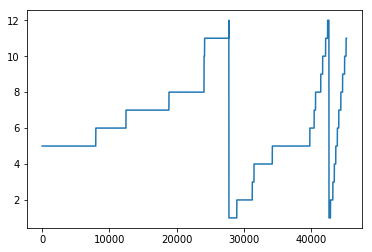

In [112]:
df['nmonth'].plot()
plt.show()

In [341]:
print(df.dtypes)

age           int64
job          object
marital      object
education    object
default        int8
balance       int64
housing        int8
loan           int8
contact      object
day           int64
month        object
duration      int64
campaign      int64
pdays         int64
previous      int64
poutcome     object
y              int8
nmonth         int8
dtype: object


In [48]:
df[label_name].mean()

0.11698480458295547

In [352]:
flname = 'dfbank'
flname += '.csv'
flname = os.path.join(ExpDir,  flname)
print("Full file name:", flname)

StartTime = time.time()
df.to_csv(flname, index = False)
print("Writing time:", time.time() - StartTime, "s")

Full file name: C:\Privat\Schibsted\Export\dfbank.csv
Writing time: 0.5804769992828369 s


## Data visualization

In [118]:
df.corr()

,age,default,balance,housing,loan,day,duration,campaign,pdays,previous,y,id,nmonth
age,1.000000,-0.017879,0.097783,-0.185513,-0.015655,-0.009120,-0.004648,0.004760,-0.023758,0.001288,0.025155,0.014973,0.092903
default,-0.017879,1.000000,-0.066745,-0.006025,0.077234,0.009424,-0.010021,0.016822,-0.029979,-0.018329,-0.022419,-0.053098,0.014989
balance,0.097783,-0.066745,1.000000,-0.068768,-0.084350,0.004503,0.021560,-0.014578,0.003435,0.016674,0.052838,0.073639,0.094605
housing,-0.185513,-0.006025,-0.068768,1.000000,0.041323,-0.027982,0.005075,-0.023599,0.124178,0.037076,-0.139173,-0.176143,-0.173887
loan,-0.015655,0.077234,-0.084350,0.041323,1.000000,0.011370,-0.012412,0.009980,-0.022754,-0.011043,-0.068185,-0.084240,0.021638
day,-0.009120,0.009424,0.004503,-0.027982,0.011370,1.000000,-0.030206,0.162490,-0.093044,-0.051710,-0.028348,-0.061465,0.101989
duration,-0.004648,-0.010021,0.021560,0.005075,-0.012412,-0.030206,1.000000,-0.084570,-0.001565,0.001203,0.394521,0.013031,-0.011866
campaign,0.004760,0.016822,-0.014578,-0.023599,0.009980,0.162490,-0.084570,1.000000,-0.088628,-0.032855,-0.073172,-0.102884,0.054868
pdays,-0.023758,-0.029979,0.003435,0.124178,-0.022754,-0.093044,-0.001565,-0.088628,1.000000,0.454820,0.103621,0.437729,-0.108940
previous,0.001288,-0.018329,0.016674,0.037076,-0.011043,-0.051710,0.001203,-0.032855,0.454820,1.000000,0.093236,0.271098,-0.035600


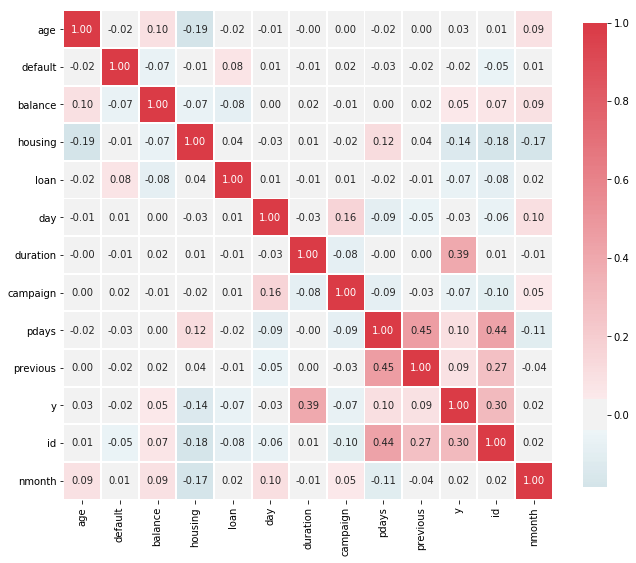

In [120]:
cName = ['age', 'default', 'balance', 'housing', 'loan' ,'day', 'duration', 'campaign', 'pdays', 'previous', 'nmonth', label_name]
#MyPlotCorrMap(df)
plt.subplots(figsize=(11, 9))
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap=sns.diverging_palette(220, 10, as_cmap=True),
            #vmax=0.03, 
            center=0,
            square=True, linewidths=.95, cbar_kws={"shrink": .95})
plt.show()

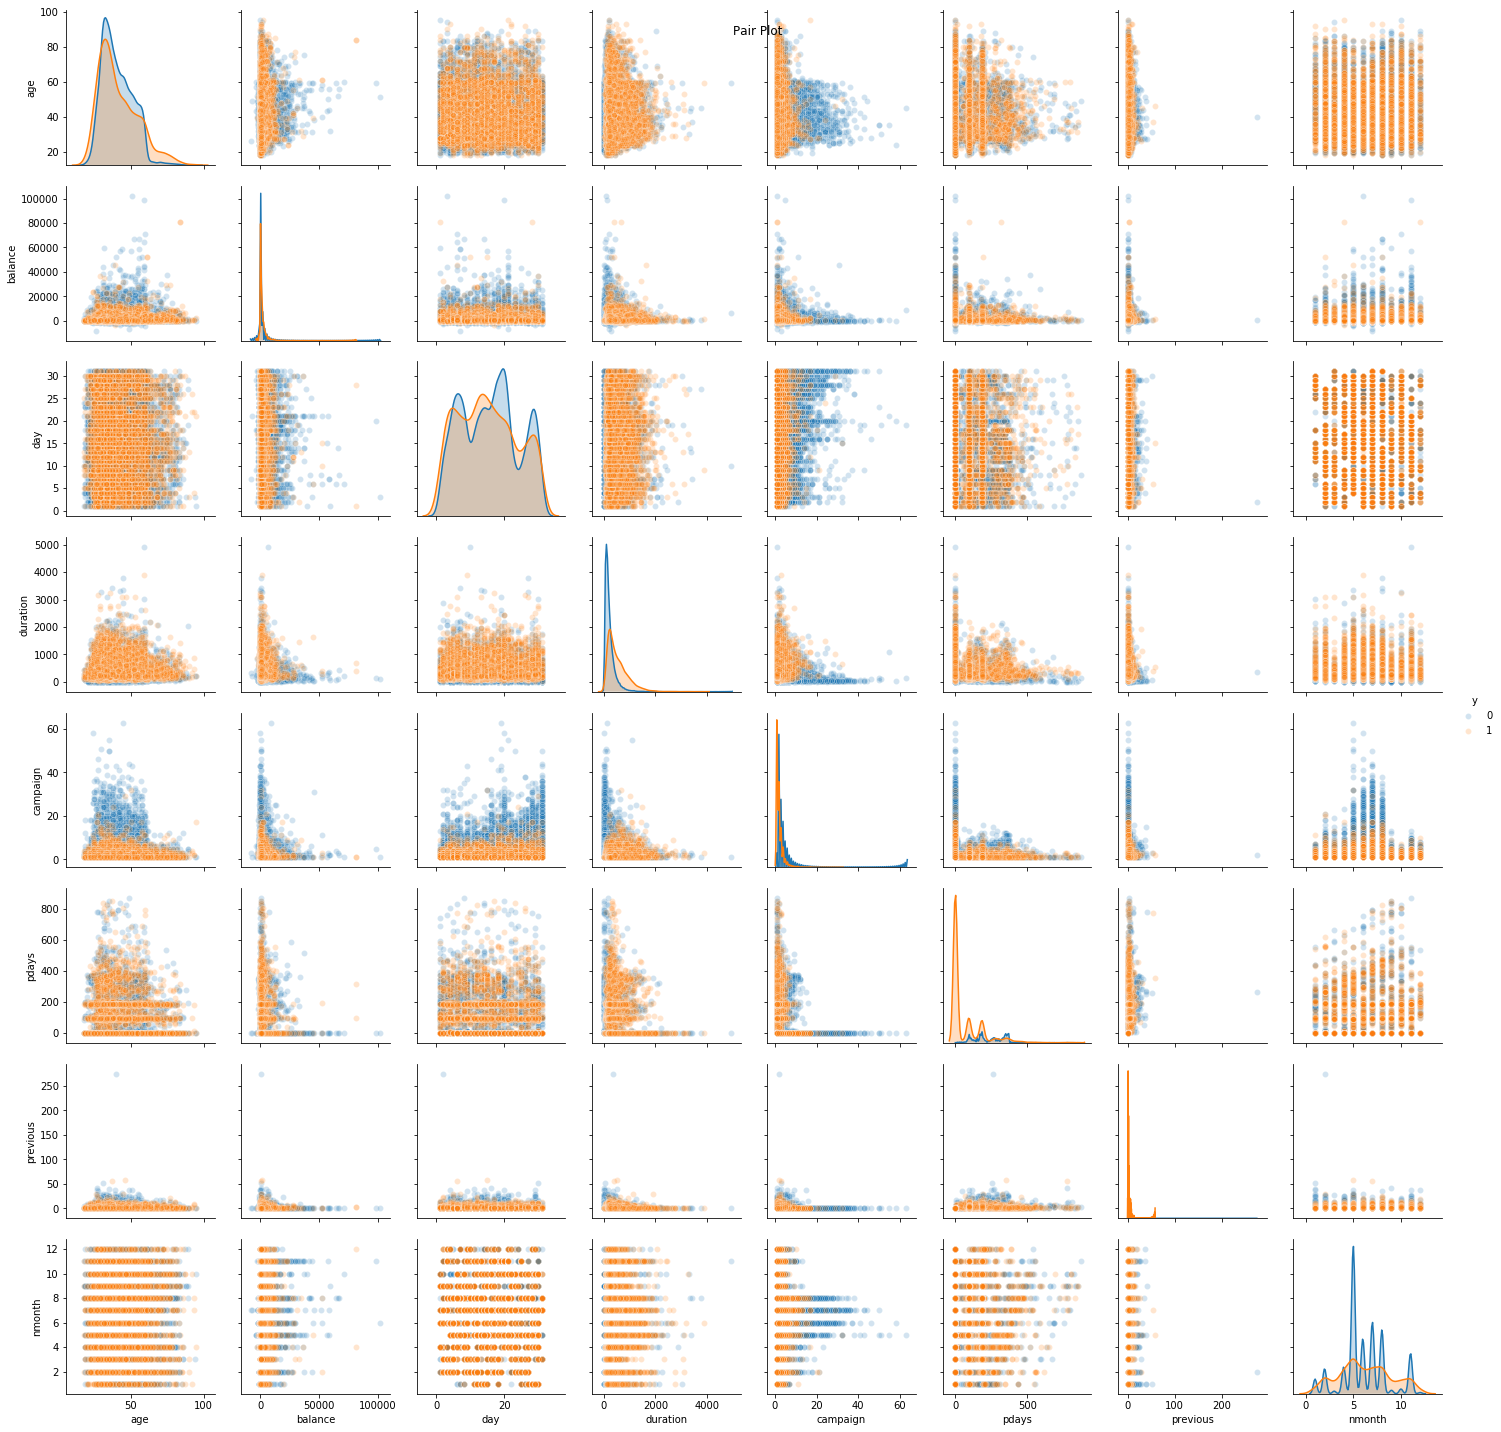

In [121]:
cName = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous', 'nmonth']
sns.pairplot(df, vars = cName, hue = label_name, diag_kind = 'kde', plot_kws = {'alpha': 0.2})
# Title 
plt.suptitle('Pair Plot')
plt.show()

### Categorical values

In [130]:
#MyGroup(df, 'job')

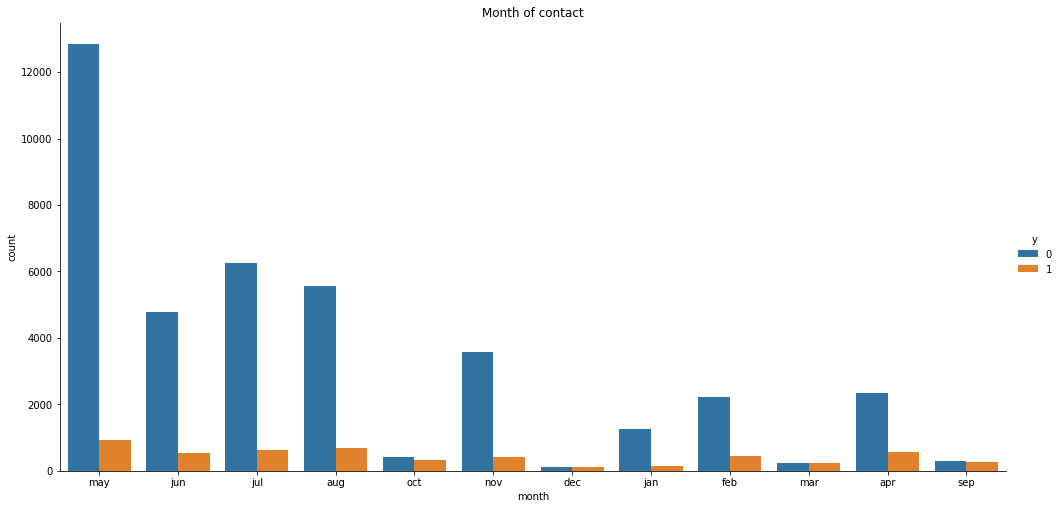

In [369]:
#sns.countplot(x="job", hue=label_name, data=df)
sns.catplot(x="month", kind="count", hue=label_name, orient="v", data=df, height = 7, aspect=2);
plt.title("Month of contact")
plt.show()

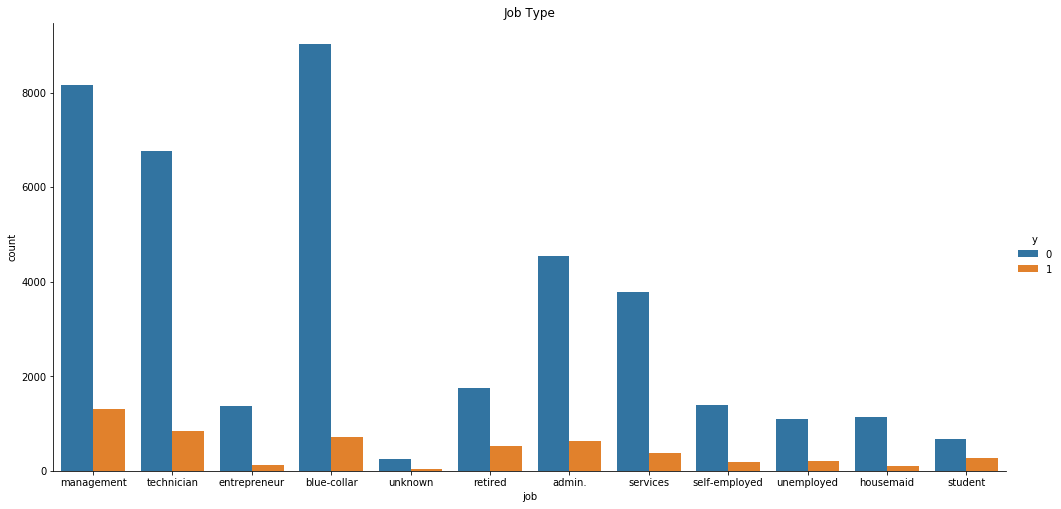

In [151]:
#sns.countplot(x="job", hue=label_name, data=df)
sns.catplot(x="job", kind="count", hue=label_name, orient="v", data=df, height = 7, aspect=2);
plt.title("Job Type")
plt.show()

blue-collar      21.525735
management       20.919688
technician       16.803433
admin.           11.437482
services          9.188029
retired           5.007631
self-employed     3.492513
entrepreneur      3.289023
unemployed        2.882042
housemaid         2.742695
student           2.074716
unknown           0.637013
Name: job, dtype: float64

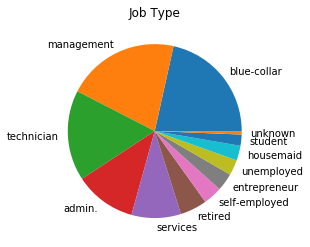

In [365]:
display(100*df["job"].value_counts(normalize =True))
df["job"].value_counts().plot.pie()
plt.title("Job Type")
plt.axis('off')
plt.show()

In [152]:
df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'y', 'id', 'nmonth'],
      dtype='object')

married     60.193316
single      28.289576
divorced    11.517109
Name: marital, dtype: float64

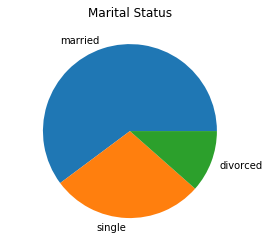

In [366]:
display(100*df["marital"].value_counts(normalize =True))
df["marital"].value_counts().plot.pie()
plt.title("Marital Status")
plt.axis('off')
plt.show()

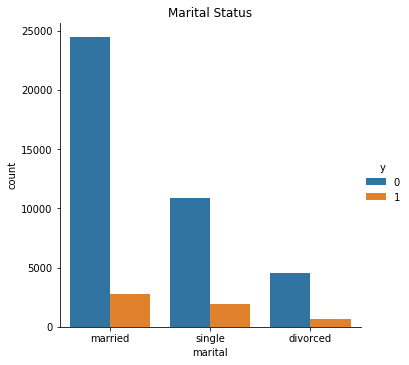

In [368]:
sns.catplot(x="marital", kind="count", hue=label_name, orient="v", data=df);
plt.title("Marital Status")
plt.show()

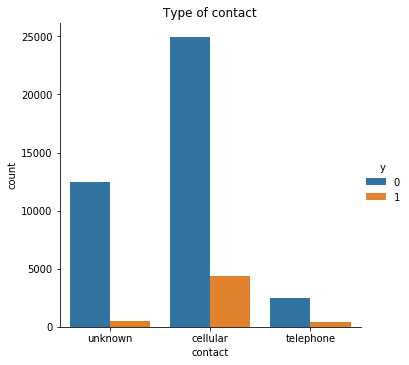

In [370]:
sns.catplot(x="contact", kind="count", hue=label_name, orient="v", data=df);
plt.title("Type of contact")
plt.show()

In [154]:
100*df["education"].value_counts(normalize =True)

secondary    51.319369
tertiary     29.419831
primary      15.153392
unknown       4.107407
Name: education, dtype: float64

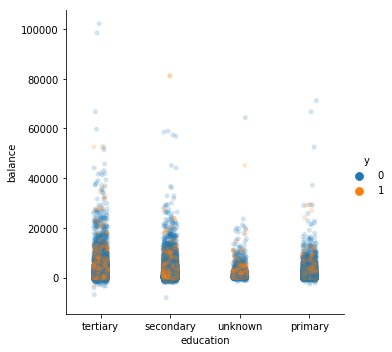

In [161]:
sns.catplot(x="education", y="balance", hue=label_name, data=df, alpha=0.2)
plt.show()

In [372]:
df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'y', 'id', 'nmonth'],
      dtype='object')

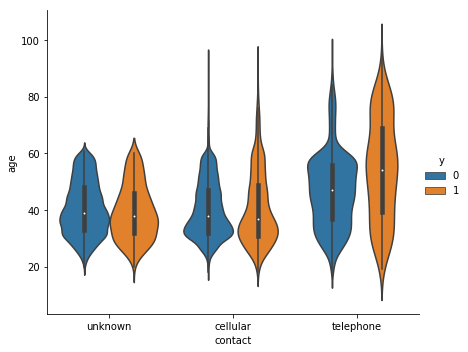

In [381]:
sns.catplot(x="contact", y="age", hue=label_name, data=df, kind="violin", aspect=1.2)
plt.show()

## PCA - Principal Component Analysis

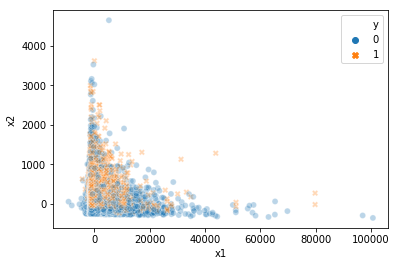

In [390]:
from sklearn import decomposition

cName = ['age', 'default', 'balance', 'housing', 'loan', 'day', 'duration', 'campaign', 'pdays', 'previous', 'nmonth']
cName = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous', 'nmonth']
cName.append(label_name)
dft = df[cName].reset_index(drop=True)

pca = decomposition.PCA(n_components=2)
tmp = pd.DataFrame(pca.fit_transform(dft[dft.columns[:-1]]), columns=["x1","x2"])
dft = pd.concat([tmp, dft[label_name]], axis=1)

sns.scatterplot(x="x1", y="x2", hue=label_name, style=label_name, data=dft, alpha=0.3)
plt.show()

### Normalization and Standardization

In [394]:
from sklearn import preprocessing

df['sbalance'] = preprocessing.scale(df['balance'])
df[['balance', 'sbalance']].describe()

C:\Users\E215947\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


,balance,sbalance
count,45211.000000,4.521100e+04
mean,1362.272058,3.070663e-15
std,3044.765829,1.000011e+00
min,-8019.000000,-3.081149e+00
25%,72.000000,-4.237719e-01
50%,448.000000,-3.002800e-01
75%,1428.000000,2.158743e-02
max,102127.000000,3.309478e+01


In [ ]:
from sklearn import decomposition

cName = ['age', 'default', 'balance', 'housing', 'loan', 'day', 'duration', 'campaign', 'pdays', 'previous', 'nmonth']
cName = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous', 'nmonth']
cName.append(label_name)
dft = df[cName].reset_index(drop=True)

for i in cName[:-1]:
    dft[i] = preprocessing.scale(dft[i])

pca = decomposition.PCA(n_components=2)
tmp = pd.DataFrame(pca.fit_transform(dft[dft.columns[:-1]]), columns=["x1","x2"])
dft = pd.concat([tmp, dft[label_name]], axis=1)

sns.scatterplot(x="x1", y="x2", hue=label_name, style=label_name, data=dft, alpha=0.3)
plt.show()

 ## One-hot encode categorical variables for scikit-learn models

In [198]:
#Make copy of working DataFrame
dfw = df.copy()
#Remove ID column
if "id" in dfw.columns:
    dfw.drop(columns="id", inplace = True)

In [190]:
#Check category fields
cName = ['job', 'marital', 'education', 'contact', 'month', 'poutcome']
cName = [_ for _ in dfw.columns if _ in cName]
for i in cName:
    tmp = dfw[i].unique()
    print(i, "(", tmp.size,"):", list(tmp), sep=" ")

job ( 12 ): ['management', 'technician', 'entrepreneur', 'blue-collar', 'unknown', 'retired', 'admin.', 'services', 'self-employed', 'unemployed', 'housemaid', 'student']
marital ( 3 ): ['married', 'single', 'divorced']
education ( 4 ): ['tertiary', 'secondary', 'unknown', 'primary']
contact ( 3 ): ['unknown', 'cellular', 'telephone']
month ( 12 ): ['may', 'jun', 'jul', 'aug', 'oct', 'nov', 'dec', 'jan', 'feb', 'mar', 'apr', 'sep']
poutcome ( 4 ): ['unknown', 'failure', 'other', 'success']


Convert to dummies variables and remove original categorical features

In [191]:
dfw = dfw.join(list(map(lambda x: pd.get_dummies(dfw[x], prefix=x),cName)))

#Remove original column
dfw.drop(columns=cName, inplace = True)

##### Write in one function:

In [216]:
def MyOneHotEncoding(object):
    '''Convert to dummies variables and remove original categorical features'''
    
    res = None
    if object is None:
        return res
    
    dfw = object
    #Remove ID column
    if "id" in dfw.columns:
        dfw.drop(columns="id", inplace = True)
    
    #Category fields
    cName = ['job', 'marital', 'education', 'contact', 'month', 'poutcome']
    cName = [_ for _ in dfw.columns if _ in cName]
    
    #Convert to dummies variables
    dfw = dfw.join(list(map(lambda x: pd.get_dummies(dfw[x], prefix=x),cName)))

    #Remove original column
    dfw.drop(columns=cName, inplace = True)
    
    res = dfw

    return res

In [217]:
dfw = MyOneHotEncoding(df)

In [202]:
print(dfw.shape)
#dfw.head()

(45211, 50)


In [203]:
dfw.columns

Index(['age', 'default', 'balance', 'housing', 'loan', 'day', 'duration',
       'campaign', 'pdays', 'previous', 'y', 'nmonth', 'job_admin.',
       'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'job_unknown',
       'marital_divorced', 'marital_married', 'marital_single',
       'education_primary', 'education_secondary', 'education_tertiary',
       'education_unknown', 'contact_cellular', 'contact_telephone',
       'contact_unknown', 'month_apr', 'month_aug', 'month_dec', 'month_feb',
       'month_jan', 'month_jul', 'month_jun', 'month_mar', 'month_may',
       'month_nov', 'month_oct', 'month_sep', 'poutcome_failure',
       'poutcome_other', 'poutcome_success', 'poutcome_unknown'],
      dtype='object')

## Machine Learning

In [234]:
features_name = ['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome']

##### Create working DataFrame

In [238]:
#[_ for _ in df.columns if (_ in features_name) or (_==label_name)]
tmp = features_name.copy()
tmp.append(label_name)
dfw = MyOneHotEncoding(df[tmp])
print(dfw.shape)

(45211, 49)


In [239]:
dfw.columns

Index(['age', 'default', 'balance', 'housing', 'loan', 'day', 'duration',
       'campaign', 'pdays', 'previous', 'y', 'job_admin.', 'job_blue-collar',
       'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired',
       'job_self-employed', 'job_services', 'job_student', 'job_technician',
       'job_unemployed', 'job_unknown', 'marital_divorced', 'marital_married',
       'marital_single', 'education_primary', 'education_secondary',
       'education_tertiary', 'education_unknown', 'contact_cellular',
       'contact_telephone', 'contact_unknown', 'month_apr', 'month_aug',
       'month_dec', 'month_feb', 'month_jan', 'month_jul', 'month_jun',
       'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep',
       'poutcome_failure', 'poutcome_other', 'poutcome_success',
       'poutcome_unknown'],
      dtype='object')

In [249]:
#dfw.dtypes

##### Ratio of imballanced DataSet

In [250]:
dfw[label_name].mean()

0.11698480458295547

### Separation of feaures and label (target)

In [258]:
y = dfw[label_name]
X = dfw.drop(columns = label_name)

##### For gold and working sets:

In [255]:
print(dfw.shape, "->")
df_work, df_gold = train_test_split(dfw, test_size=0.25, random_state=77, stratify=dfw[label_name])
print("Work:", df_work.shape)
print("Gold:", df_gold.shape)

(45211, 49) ->
Work: (33908, 49)
Gold: (11303, 49)


In [256]:
y = df_work[label_name]
X = df_work.drop(columns = label_name)

y_gold = df_gold[label_name]
X_gold = df_gold.drop(columns = label_name)
print("Gold:", X_gold.shape, " - ", y_gold.shape)

Gold: (11303, 48)  -  (11303,)


In [257]:
#Checking that it is stratisfied:
print("Work:\n", df_work[label_name].value_counts(normalize=True))
print("Gold:\n", df_gold[label_name].value_counts(normalize=True))

Work:
 0    0.883007
1    0.116993
Name: y, dtype: float64
Gold:
 0    0.88304
1    0.11696
Name: y, dtype: float64


### Splitting in train and test sets

In [259]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=7, stratify=y)
print("Train:", X_train.shape, " - ", y_train.shape)
print("Test:", X_test.shape, " - ", y_test.shape)

Train: (31647, 48)  -  (31647,)
Test: (13564, 48)  -  (13564,)


Checking that it is stratisfied

In [261]:
print("Train:", y_train.size, "\n", y_train.value_counts(normalize=True))
print("Test:", y_test.size, "\n", y_test.value_counts(normalize=True))

Train: 31647 
 0    0.883022
1    0.116978
Name: y, dtype: float64
Test: 13564 
 0    0.882999
1    0.117001
Name: y, dtype: float64


In [262]:
sweight = 1/dfw[label_name].mean()
print("Weight:", sweight)

Weight: 8.548118737001325


### Decision Tree

In [278]:
from sklearn import tree

model = tree.DecisionTreeClassifier(class_weight = "balanced", random_state = 1, 
                                    criterion='entropy'
                                    #'criterion=gini'
                                   )

StartTime = time.time()
model.fit(X_train, y_train)
print("Tree:", time.time()-StartTime)

Tree: 0.29920053482055664


In [279]:
score = model.score(X_test, y_test)
print("Score:", score)

Score: 0.8781332940135653


In [280]:
#Predicted:
y_pred = model.predict(X_test)

MyReport(y_test, y_pred)

Confussion matrix:
 [[  745   811]
 [  842 11166]] 
 
Accuracy: 0.8781332940135653
Balanced accuracy: 0.7008630383197705
Precision: 0.4787917737789203
Recall: 0.4694391934467549 
 
F1 score: 0.47406936048361437
Matthews correlation: 0.4051840821530416


Clasification report:
               precision    recall  f1-score   support

           1      0.479     0.469     0.474      1587
           0      0.930     0.932     0.931     11977

   micro avg      0.878     0.878     0.878     13564
   macro avg      0.704     0.701     0.703     13564
weighted avg      0.877     0.878     0.878     13564



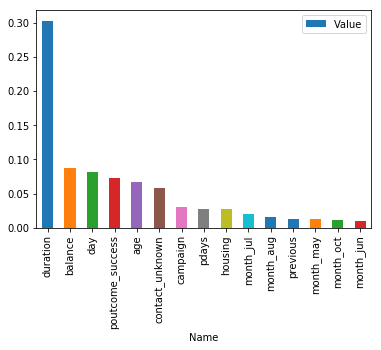

In [281]:
dft = pd.DataFrame(list(zip(X_train.columns, model.feature_importances_)), columns =["Name","Value"]).sort_values(by=['Value'], ascending=False)
#dft.head(20).T
# plot
dft[0:15].plot(x="Name", y="Value", kind = "bar")
plt.show()

### Random Forest

In [282]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=400, random_state=3, oob_score=True, max_features=None, class_weight="balanced_subsample", n_jobs=-1, bootstrap=True)

StartTime = time.time()
model.fit(X_train, y_train)
print("Forest:", time.time()-StartTime)

Forest: 40.86275768280029


In [283]:
print("Out-of-Bag:", model.oob_score_)

Out-of-Bag: 0.9019180333048946


In [284]:
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)
y_pred_prob = y_prob[:,1]

MyReport(y_test, y_pred)

Confussion matrix:
 [[  693   411]
 [  894 11566]] 
 
Accuracy: 0.9037894426422884
Balanced accuracy: 0.7011785979838799
Precision: 0.6277173913043478
Recall: 0.43667296786389415 
 
F1 score: 0.5150501672240803
Matthews correlation: 0.47296685092538643


Clasification report:
               precision    recall  f1-score   support

           1      0.628     0.437     0.515      1587
           0      0.928     0.966     0.947     11977

   micro avg      0.904     0.904     0.904     13564
   macro avg      0.778     0.701     0.731     13564
weighted avg      0.893     0.904     0.896     13564



In [288]:
print("ROC AUC:", metrics.roc_auc_score(y_test, y_pred_prob))

ROC AUC: 0.9306316154481976


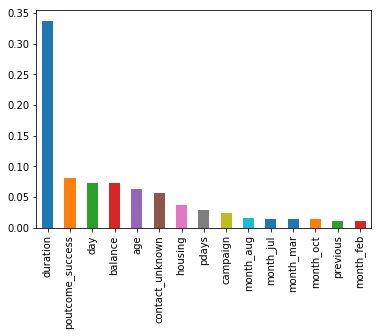

In [285]:
dft = pd.DataFrame(list(zip(X_train.columns, model.feature_importances_)), columns =["Name","Value"]).sort_values(by=['Value'], ascending=False)
#dft.head(20).T
# plot
dft[0:15].plot(x="Name", y="Value", kind = "bar", legend=None)
#plt.ylabel("")
plt.xlabel("")
plt.show()

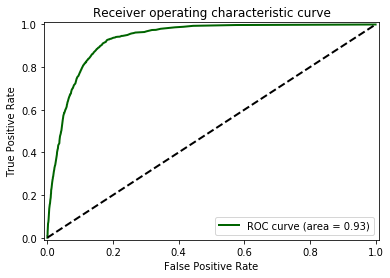

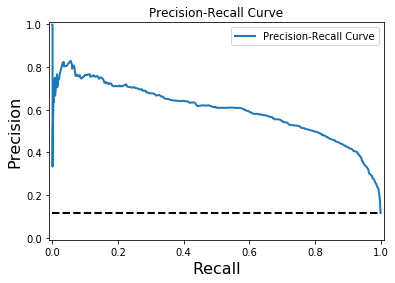

In [286]:
MyPlotROC(y_test, y_pred_prob)
MyPlotPRC(y_test, y_pred_prob)

sns.distplot(y_pred_prob)
plt.show()

#### XGBoost

In [292]:
#Fit model on training data
model = xgb.XGBClassifier(booster='gbtree', 
                          n_estimators=300,
                          max_depth=60, 
                          learning_rate=0.1, 
                          subsample=0.6,
                          colsample_bytree=0.8,
                          scale_pos_weight=sweight, random_state=4, n_jobs=-1, silent=True)

StartTime = time.time()
model.fit(X_train, y_train, 
          #eval_metric='aucpr',
          eval_metric='auc', 
          verbose=False)
print("Tree:", time.time()-StartTime)

Tree: 46.5286328792572


In [266]:
# plot single tree
#xgb.plot_tree(model, num_trees=1)
#xgb.to_graphviz(model, num_trees=3, rankdir='TD')
#plt.show()

In [298]:
#Predicted:
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)
y_pred_prob = y_prob[:,1]

MyReport(y_test, y_pred)

Confussion matrix:
 [[  928   638]
 [  659 11339]] 
 
Accuracy: 0.904379239162489
Balanced accuracy: 0.7657411687881714
Precision: 0.5925925925925926
Recall: 0.5847511027095148 
 
F1 score: 0.5886457342213763
Matthews correlation: 0.5345656111451759


Clasification report:
               precision    recall  f1-score   support

           1      0.593     0.585     0.589      1587
           0      0.945     0.947     0.946     11977

   micro avg      0.904     0.904     0.904     13564
   macro avg      0.769     0.766     0.767     13564
weighted avg      0.904     0.904     0.904     13564



In [299]:
print("ROC AUC:", metrics.roc_auc_score(y_test, y_pred_prob))

ROC AUC: 0.9323258678061749


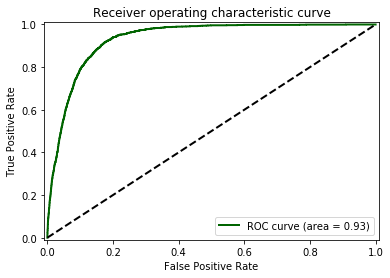

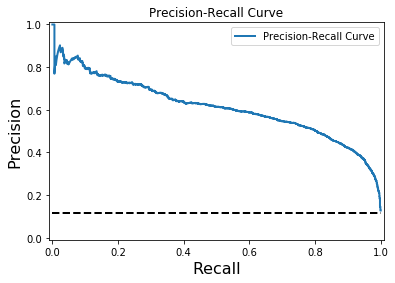

In [300]:
MyPlotROC(y_test, y_pred_prob)
MyPlotPRC(y_test, y_pred_prob)

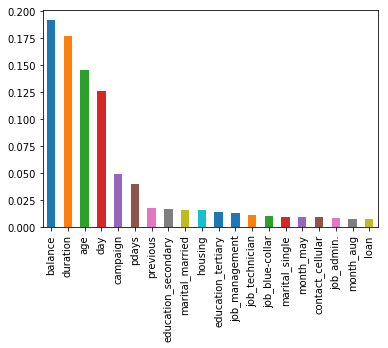

In [301]:
dft = pd.DataFrame(list(zip(X_train.columns, model.feature_importances_)), columns =["Name","Value"]).sort_values(by=['Value'], ascending=False)
dft.head(20).T
# plot
dft[0:20].plot(x="Name", y="Value", kind = "bar", legend=None)
#plt.ylabel("")
plt.xlabel("")
plt.show()

### Logistic regression

In [325]:
from sklearn.linear_model import LogisticRegression
#https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
    
model = LogisticRegression(random_state=5, class_weight='balanced', penalty="l1", C=0.1, fit_intercept=True, multi_class='auto', dual=False,
                           solver='liblinear',#'saga',
                           tol=1e-5,
                           max_iter = 2000, n_jobs=-1)

StartTime = time.time()
model.fit(X_train, y_train)
print("Logistic regression:", time.time()-StartTime)

C:\Users\E215947\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


Logistic regression: 0.5964052677154541


In [326]:
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)
y_pred_prob = y_prob[:,1]

MyReport(y_test, y_pred)

Confussion matrix:
 [[ 1322  1793]
 [  265 10184]] 
 
Accuracy: 0.8482748451784135
Balanced accuracy: 0.8416573374540228
Precision: 0.4243980738362761
Recall: 0.8330182734719597 
 
F1 score: 0.5623139089749043
Matthews correlation: 0.5221759263114314


Clasification report:
               precision    recall  f1-score   support

           1      0.424     0.833     0.562      1587
           0      0.975     0.850     0.908     11977

   micro avg      0.848     0.848     0.848     13564
   macro avg      0.700     0.842     0.735     13564
weighted avg      0.910     0.848     0.868     13564



In [327]:
print("ROC AUC:", metrics.roc_auc_score(y_test, y_pred_prob))

ROC AUC: 0.9146656801086772


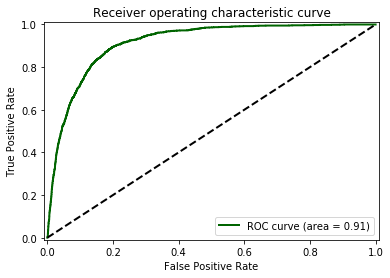

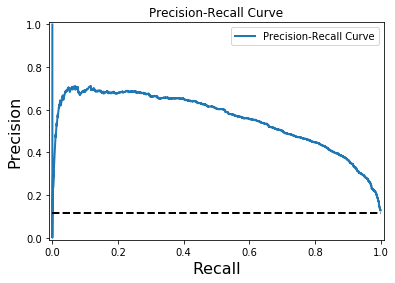

In [328]:
MyPlotROC(y_test, y_pred_prob)
MyPlotPRC(y_test, y_pred_prob)

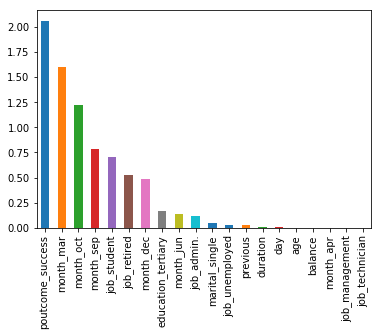

In [330]:
dft = pd.DataFrame(list(zip(X_train.columns, model.coef_[0])), columns =["Name","Value"]).sort_values(by=['Value'], ascending=False)
#display(dft.head(15).T)
# plot
dft[0:20].plot(x="Name", y="Value", kind = "bar", legend=None)
#plt.ylabel("")
plt.xlabel("")
plt.show()

### Logistic regression with cross-validation

In [335]:
metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'accuracy', 'roc_auc', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'brier_score_loss', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted'])

In [336]:
from sklearn.linear_model import LogisticRegressionCV
#https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html#sklearn.linear_model.LogisticRegressionCV

model = LogisticRegressionCV(random_state=6, Cs=10, class_weight='balanced', penalty="l1", fit_intercept=True, multi_class='auto', dual=False, cv=5,
                           scoring='roc_auc',
                           solver='liblinear',#'liblinear',
                           tol=1e-5,
                           max_iter = 300, n_jobs=-1)

StartTime = time.time()
model.fit(X_train, y_train)
print("Logistic regression CV:", time.time()-StartTime)

Logistic regression CV: 48.30462408065796


In [337]:
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)
y_pred_prob = y_prob[:,1]

MyReport(y_test, y_pred)

Confussion matrix:
 [[ 1319  1787]
 [  268 10190]] 
 
Accuracy: 0.8484960188734887
Balanced accuracy: 0.8409626379567349
Precision: 0.42466194462330975
Recall: 0.8311279143037177 
 
F1 score: 0.5621137864905178
Matthews correlation: 0.5216440184438027


Clasification report:
               precision    recall  f1-score   support

           1      0.425     0.831     0.562      1587
           0      0.974     0.851     0.908     11977

   micro avg      0.848     0.848     0.848     13564
   macro avg      0.700     0.841     0.735     13564
weighted avg      0.910     0.848     0.868     13564



In [338]:
print("ROC AUC:", metrics.roc_auc_score(y_test, y_pred_prob))

ROC AUC: 0.9145984434880148


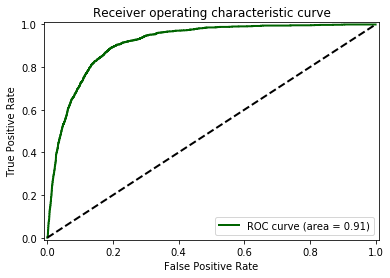

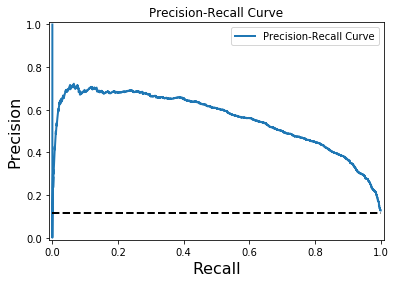

In [339]:
MyPlotROC(y_test, y_pred_prob)
MyPlotPRC(y_test, y_pred_prob)

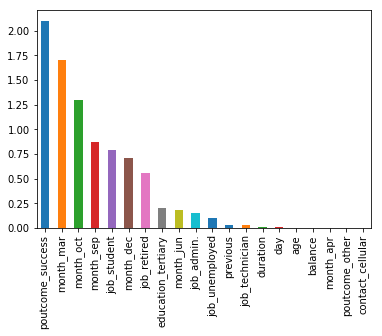

In [340]:
dft = pd.DataFrame(list(zip(X_train.columns, model.coef_[0])), columns =["Name","Value"]).sort_values(by=['Value'], ascending=False)
#display(dft.head(15).T)
# plot
dft[0:20].plot(x="Name", y="Value", kind = "bar", legend=None)
#plt.ylabel("")
plt.xlabel("")
plt.show()

## SVM

#### Linear

In [360]:
from sklearn.svm import LinearSVC
#https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html

model = LinearSVC(random_state=4, class_weight='balanced', penalty="l2", dual=False, C=0.9, fit_intercept=True, 
                  loss='squared_hinge', tol=1e-5,
                  max_iter = 20000)

StartTime = time.time()
model.fit(X_train, y_train)
print("Linear SVM:", time.time()-StartTime)

Linear SVM: 0.6382927894592285


In [361]:
y_pred = model.predict(X_test)
#y_prob = model.predict_proba(X_test)
#y_pred_prob = y_prob[:,1]

MyReport(y_test, y_pred)

Confussion matrix:
 [[ 1304  1698]
 [  283 10279]] 
 
Accuracy: 0.8539516366853436
Balanced accuracy: 0.8399521946574875
Precision: 0.4343770819453698
Recall: 0.8216761184625079 
 
F1 score: 0.5683155371540641
Matthews correlation: 0.526419426272216


Clasification report:
               precision    recall  f1-score   support

           1      0.434     0.822     0.568      1587
           0      0.973     0.858     0.912     11977

   micro avg      0.854     0.854     0.854     13564
   macro avg      0.704     0.840     0.740     13564
weighted avg      0.910     0.854     0.872     13564



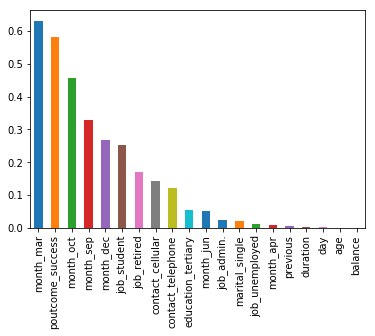

In [362]:
dft = pd.DataFrame(list(zip(X_train.columns, model.coef_[0])), columns =["Name","Value"]).sort_values(by=['Value'], ascending=False)
#display(dft.head(15).T)
# plot
dft[0:20].plot(x="Name", y="Value", kind = "bar", legend=None)
#plt.ylabel("")
plt.xlabel("")
plt.show()

#### Non-linear SVM

In [363]:
from sklearn.svm import SVC
#https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

model = SVC(random_state=9, class_weight='balanced', C=1.0, gamma='scale', kernel='rbf',
           tol=1e-5,
           max_iter=-1)

StartTime = time.time()
model.fit(X_train, y_train)
print("Non-linaer SVM:", time.time()-StartTime)

Non-linaer SVM: 91.96270489692688


In [364]:
y_pred = model.predict(X_test)
MyReport(y_test, y_pred)

Confussion matrix:
 [[1155 2328]
 [ 432 9649]] 
 
Accuracy: 0.7965202005308168
Balanced accuracy: 0.7667078661953368
Precision: 0.33161068044788977
Recall: 0.7277882797731569 
 
F1 score: 0.455621301775148
Matthews correlation: 0.39246394411898317


Clasification report:
               precision    recall  f1-score   support

           1      0.332     0.728     0.456      1587
           0      0.957     0.806     0.875     11977

   micro avg      0.797     0.797     0.797     13564
   macro avg      0.644     0.767     0.665     13564
weighted avg      0.884     0.797     0.826     13564



## SMOTE - Synthetic Minority Over-sampling Technique

In [382]:
from imblearn.over_sampling import SMOTE